In [104]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks/AI RESIDENCY/P1')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: ignored

In [105]:
## Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

## ignore warnings
import warnings
warnings.filterwarnings("ignore",module = "matplotlib\..*")

In [106]:
## Load data
data = pd.read_csv('data.csv')
data.head()

,Unnamed: 0,Happy,delivered_on_time,contents_as_expected,ordered_everything_I_wanted,paid_a_good_price,satisfied_with_my_courier,app_makes_ordering_easy
0,0,0,3,3,3,4,2,4
1,1,0,3,2,3,5,4,3
2,2,1,5,3,3,3,3,5
3,3,0,5,4,3,3,3,5
4,4,0,5,4,3,3,3,5


In [107]:
data = data.drop('Unnamed: 0',axis=1)
data.columns

Index(['Happy', 'delivered_on_time', 'contents_as_expected',
       'ordered_everything_I_wanted', 'paid_a_good_price',
       'satisfied_with_my_courier', 'app_makes_ordering_easy'],
      dtype='object')

In [108]:
## split the data frame into the response variable, y, and the design matrix, X
df = data.copy()
y = df['Happy'] ## response 
X = df.drop('Happy',axis=1) ## design matrix
from sklearn.model_selection import train_test_split
# split the data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, ## features to split
                                                    y, ## response to split
                                                    test_size=0.1, ## we will leave 10% to test our models on later. We have a small dataset so we need as many data to train on as possible.
                                                    random_state=42, ## make our work reproducible
                                                    shuffle=True) ## prevent data ordering affecting our models

In [109]:
rf_hyperparams = {"rf__n_estimators": [10,15,20,25,30,35,40,45,50,70,80,90,100,500], ## number of trees used in random forest
                 "rf__max_depth": [2,3,4,5,6,7,9,10,11,14,16,18,20,30,35,40,50], ## max depth 
                 "rf__criterion": ["gini", "entropy"], ## to check whether impurity or information gain is the best way to split
                 "rf__min_samples_leaf": [2,3,4,5,6,7,8,9,10], ## minimum samples beyond which a node cannot be split
                 "rf__max_features": ["sqrt", "log2"], ## to check what is the best way to limit the number of features to each tree
                 "rf__bootstrap": [True,False] ## to check whether bagging and aggregating results in a better model 
                 } 

In [110]:
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import make_scorer, balanced_accuracy_score, f1_score,  precision_score, recall_score, confusion_matrix,classification_report,PrecisionRecallDisplay
from sklearn.ensemble import RandomForestClassifier
## SCORING METRICS

f1_score = make_scorer(f1_score, average="weighted") ## F1-score
precision = make_scorer(precision_score, average="weighted") ## Precision
bal_acc_score = make_scorer(balanced_accuracy_score) ## Balanced Accuracy
recall = make_scorer(recall_score, average = "weighted") ## Recall

## storing the scoring metrics to use them later as the strategy of evaluating performance.
scoring_dict = {"bal_acc_score": bal_acc_score,
            "f1_wtd": f1_score,
            "pr_wtd": precision,
            "recall_wtd": recall}


In [111]:
## Randomized Search Cross Validation
from sklearn.pipeline import Pipeline
pipe = Pipeline([("rf", RandomForestClassifier())])
rscv = RandomizedSearchCV(estimator=pipe,    ## estimator
                    param_distributions=rf_hyperparams, ## parameters to try
                    scoring = scoring_dict,  ## strategy to evaluate performance of the cross-validated model on the test set.
                    refit = "bal_acc_score", ## Refit an estimator using the best found parameters on the whole dataset.
                    n_jobs = -1,      ## Number of jobs to run in parallel, -1 means using all processors
                    random_state=42)  ## make our work reproducible)

In [112]:
## fit the training data
model_rf = rscv.fit(X_train, y_train)
print(model_rf.best_params_)

{'rf__n_estimators': 20, 'rf__min_samples_leaf': 3, 'rf__max_features': 'log2', 'rf__max_depth': 2, 'rf__criterion': 'entropy', 'rf__bootstrap': True}


Balanced accuracy score:  0.4881
Precision score: 0.4790
Recall score: 0.4615
Classification Report : 
              precision    recall  f1-score   support

           0       0.50      0.14      0.22         7
           1       0.45      0.83      0.59         6

    accuracy                           0.46        13
   macro avg       0.48      0.49      0.41        13
weighted avg       0.48      0.46      0.39        13



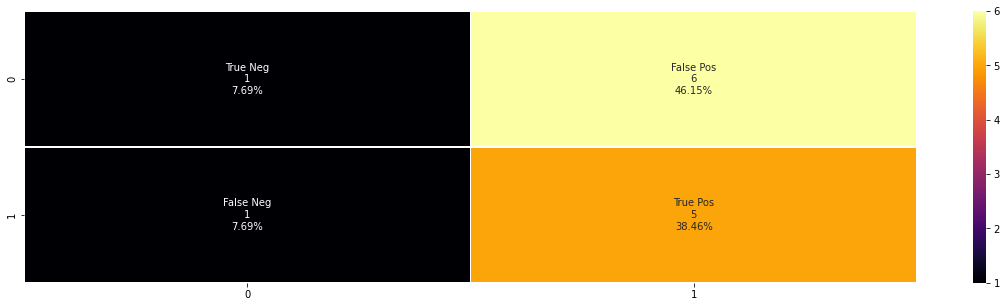

In [113]:
## train the model using the best estimator
pipe = model_rf.best_estimator_
model = pipe.fit(X_train, y_train)

## predictions
y_pred_rf = model.predict(X_test)

## HEATMAP-CONFUSION MATRIX
plt.figure(figsize=(20,5))
cf_matrix = confusion_matrix(y_test, y_pred_rf)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='inferno',linewidths=0.3)

## metric scores on test set
print(f"Balanced accuracy score: {balanced_accuracy_score(y_test, y_pred_rf): .4f}")
print(f"Precision score: {precision_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"Recall score: {recall_score(y_test, y_pred_rf, average='weighted'):.4f}")

## classification report
clf_report = classification_report(y_test, y_pred_rf)

print(f"Classification Report : \n{clf_report}")

In [114]:
from sklearn.metrics import accuracy_score
print(f'Accuracy: {round(accuracy_score(y_test, y_pred_rf),2)*100}%') ## correct predictions / total predictions

Accuracy: 46.0%


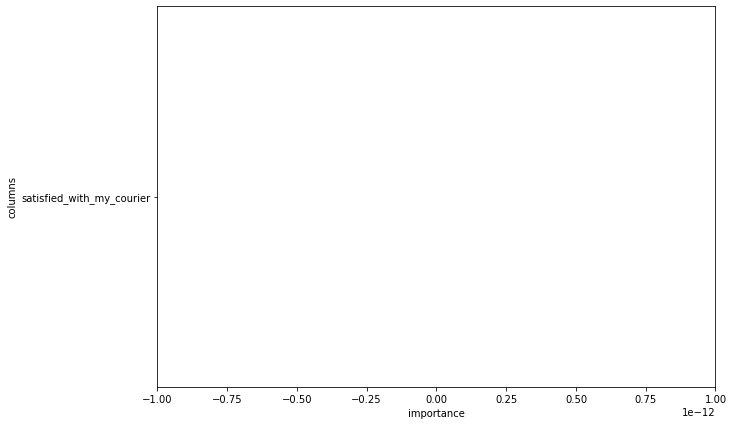

In [115]:
## We call permuation_importance and input the fitted model as model parameter
## We call it on test set, since it calculates the feature importance via its performance on our test set
from sklearn.inspection import permutation_importance
result = permutation_importance(pipe, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)

## plot the features against importance  
df = pd.DataFrame({'columns': X_test.columns, 'importance':result.importances_mean})
df = df.loc[df['importance']>0].sort_values(['importance'],ascending=False).reset_index()
plt.subplots(1,figsize=(10,7))
sns.barplot(x="importance",y="columns",data=df)
plt.show()

In [134]:
## Let's use only the first 2 most important features.
cols2drop = ['app_makes_ordering_easy','contents_as_expected','satisfied_with_my_courier','delivered_on_time']
data2 = data.copy()
for col in cols2drop:
  data2 = data2.drop(col,axis=1)

In [135]:
## split the data frame into the response variable, y, and the design matrix, X
df2 = data2.copy()
y2 = df2['Happy'] ## response 
X2 = df2.drop('Happy',axis=1) ## design matrix
#from sklearn.model_selection import train_test_split
# split the data into training and test data sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, ## data-features to split
                                                    y2, ## data-response to split
                                                    test_size=0.1, ## we will leave 10% to test our models on later
                                                    random_state=42, ## make our work reproducible
                                                    shuffle=True) ## prevent data ordering affecting our models

In [136]:
## Randomized Search Cross Validation
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipe2 = Pipeline([('scaler', StandardScaler()),
                  ("rf", RandomForestClassifier())])
rscv2 = RandomizedSearchCV(estimator=pipe2,    ## estimator
                    param_distributions=rf_hyperparams, ## parameters to try
                    scoring = scoring_dict,  ## strategy to evaluate performance of the cross-validated model on the test set.
                    refit = "bal_acc_score", ## Refit an estimator using the best found parameters on the whole dataset.
                    n_jobs = -1,      ## Number of jobs to run in parallel, -1 means using all processors
                    random_state=42)  ## make our work reproducible)

In [137]:
## fit the training data
model_rf2 = rscv2.fit(X_train2, y_train2)
print(model_rf2.best_params_)

{'rf__n_estimators': 45, 'rf__min_samples_leaf': 8, 'rf__max_features': 'log2', 'rf__max_depth': 10, 'rf__criterion': 'entropy', 'rf__bootstrap': True}


Balanced accuracy score:  0.7143
Precision score: 0.8154
Recall score: 0.6923
Classification Report : 
              precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.60      1.00      0.75         6

    accuracy                           0.69        13
   macro avg       0.80      0.71      0.67        13
weighted avg       0.82      0.69      0.67        13



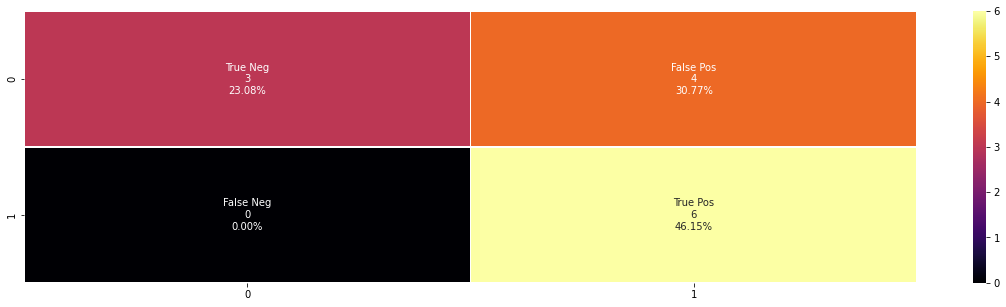

In [138]:
## train the model using the best estimator
pipe2 = model_rf2.best_estimator_
model2 = pipe2.fit(X_train2, y_train2)

## predictions
y_pred_rf2 = model2.predict(X_test2)

## HEATMAP-CONFUSION MATRIX
plt.figure(figsize=(20,5))
cf_matrix2 = confusion_matrix(y_test2, y_pred_rf2)
group_names2 = ['True Neg','False Pos','False Neg','True Pos']
group_counts2 = ['{0:0.0f}'.format(value) for value in
                cf_matrix2.flatten()]
group_percentages2 = ['{0:.2%}'.format(value) for value in
                     cf_matrix2.flatten()/np.sum(cf_matrix2)]
labels2 = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names2,group_counts2,group_percentages2)]
labels2 = np.asarray(labels2).reshape(2,2)
sns.heatmap(cf_matrix2, annot=labels2, fmt='', cmap='inferno',linewidths=0.3)

## metric scores on test set
print(f"Balanced accuracy score: {balanced_accuracy_score(y_test2, y_pred_rf2): .4f}")
print(f"Precision score: {precision_score(y_test2, y_pred_rf2, average='weighted'):.4f}")
print(f"Recall score: {recall_score(y_test2, y_pred_rf2, average='weighted'):.4f}")

## classification report
clf_report2 = classification_report(y_test2, y_pred_rf2)

print(f"Classification Report : \n{clf_report2}")

In [139]:
print(f'Accuracy: {round(accuracy_score(y_test2, y_pred_rf2),2)*100}%') ## correct predictions / total predictions

Accuracy: 69.0%
